In [ ]:
import os
import sys
sys.path.insert(0, "..")
import gc
gc.enable()
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:

import os
import sys
sys.path.insert(0, os.getcwd())
from utils.DataLoader import  DataLoader
from utils.utilities import *
from utils.visualization import *
from models.pspnet import PSPNet
import tensorflow as tf

tf.debugging.set_log_device_placement(True)
dl = DataLoader()

Using TensorFlow backend.
../utils/DataLoader.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_masks['ships'] = train_masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
../utils/DataLoader.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_masks['ships'] = test_masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)


In [3]:
train_df, valid_df = dl.train_split(0.1, filterNan=True)
print("train set shape", train_df.shape)
print("validation set shape", valid_df.shape)

train set shape (8436, 5)
validation set shape (938, 5)


In [4]:
grouped_images_gen = dl.get_grouped_images_gen(train_df, img_scaling=(3,3))#, f="adaptive_equalization") # applying filters increases dramatically the execution time
aug_gen = get_augmented_images_generator(grouped_images_gen)
valid_x, valid_y = next(dl.get_grouped_images_gen(valid_df, batch_size=100, img_scaling=(3,3)))#, f="adaptive_equalization")) #valid_df.shape[0]))

In [7]:
t_x, t_y = next(aug_gen)
x_shape =np.squeeze(t_x[0]).shape
psp_model = PSPNet(x_shape, "../models/serialized/")
psp_model.compile()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block_1_a (Conv2D)              (None, 256, 256, 8)  32          input[0][0]                      
__________________________________________________________________________________________________
block_1_batch_norm_a (BatchNorm (None, 256, 256, 8)  32          block_1_a[0][0]                  
__________________________________________________________________________________________________
block_1_leakyrelu_a (LeakyReLU) (None, 256, 256, 8)  0           block_1_batch_norm_a[0][0]       
____________________________________________________________________________________________

Steps per epoch: 200
Epoch 1/8
100/200 [==============>...............] - ETA: 2s - loss: -0.0099 - dice_coef: 0.0106 - IoU: 0.0054 - binary_accuracy: 0.0057
Epoch 00001: dice_coef improved from -inf to 0.00900, saving model to ../models/serialized/pspnet_weights.best.hdf5
200/200 [==============================] - 114s 569ms/step - loss: -0.0081 - dice_coef: 0.0090 - IoU: 0.0045 - binary_accuracy: 0.0041 - val_loss: -0.0096 - val_dice_coef: 0.0106 - val_IoU: 0.0054 - val_binary_accuracy: 0.0057
Epoch 2/8
100/200 [==============>...............] - ETA: 1s - loss: -0.0097 - dice_coef: 0.0104 - IoU: 0.0053 - binary_accuracy: 0.0057
Epoch 00002: dice_coef improved from 0.00900 to 0.00923, saving model to ../models/serialized/pspnet_weights.best.hdf5
200/200 [==============================] - 104s 521ms/step - loss: -0.0083 - dice_coef: 0.0092 - IoU: 0.0047 - binary_accuracy: 0.0043 - val_loss: -0.0094 - val_dice_coef: 0.0104 - val_IoU: 0.0053 - val_binary_accuracy: 0.0057
Epoch 3/8
100/20

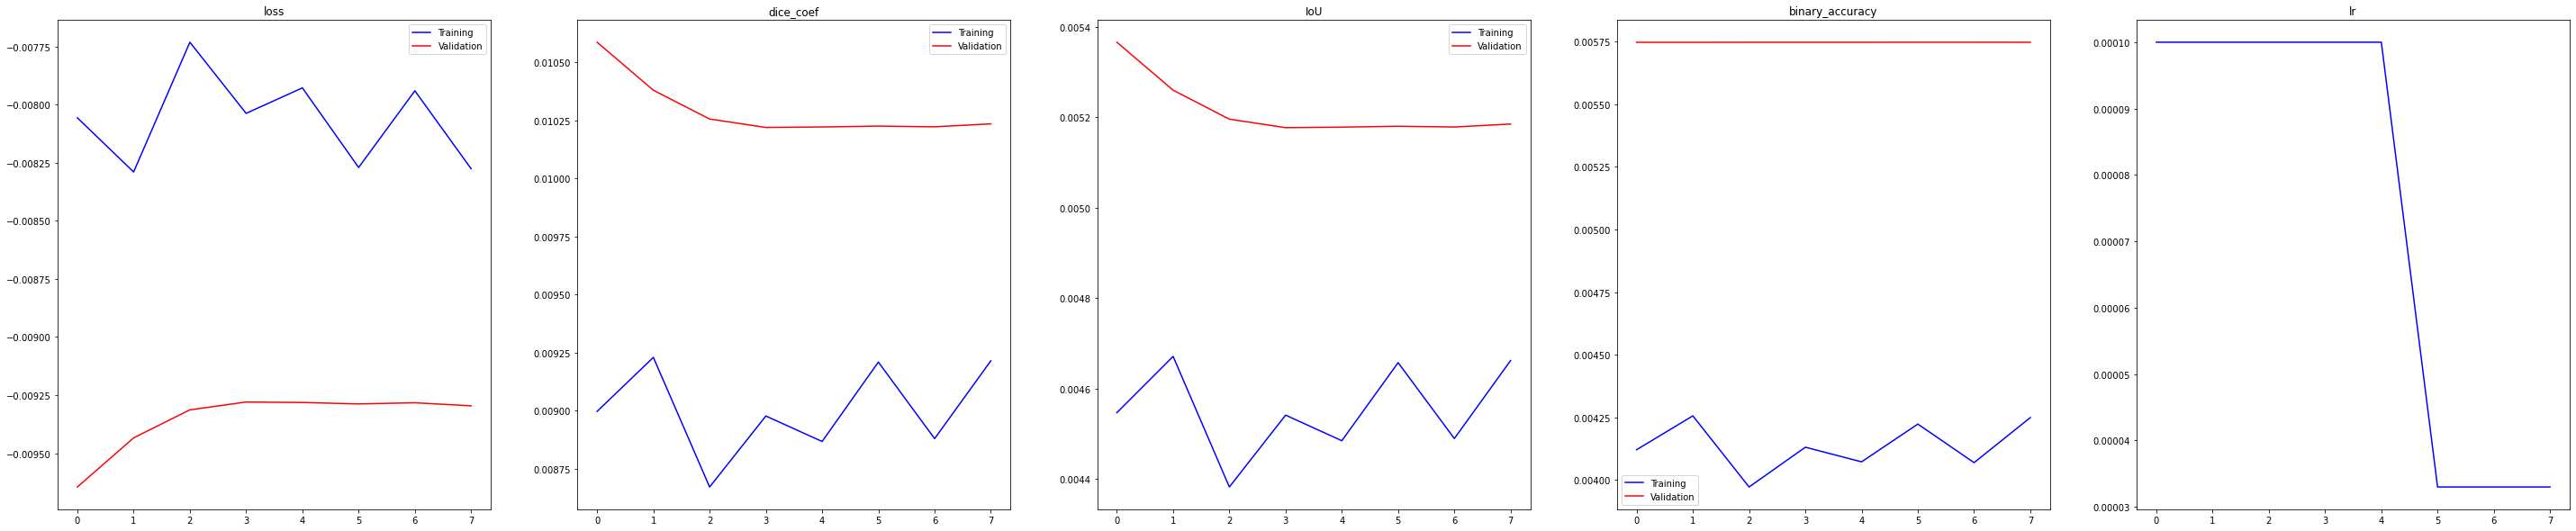

In [8]:
hl = psp_model.validate(aug_gen, train_df.shape[0], valid_set=(valid_x, valid_y), epochs=8, train_steps=200)
psp_model.show_loss(hl)

In [1]:
test_x, test_y = next(dl.get_grouped_images_gen(batch_size=40, train=False))
psp_model.examine_performance(test_x, test_y, load=True)